In [ ]:
# %% [EDA] 1. 데이터 로딩 (라벨링 ZIP 파일 직접 읽기)
import zipfile
import json
from tqdm import tqdm
import pandas as pd
import os
import glob

# 1. 구글 드라이브 마운트 (이미 실행했다면 생략 가능)
from google.colab import drive
drive.mount('/content/drive')

# 2. '2.라벨링데이터' 폴더 경로 지정
DRIVE_DATA_ROOT = "/content/drive/MyDrive/project1/Training/2.라벨링데이터"

print(f"'{DRIVE_DATA_ROOT}' 폴더에서 라벨링 압축 파일 스캔 중...")
# 해당 폴더의 모든 .zip 파일을 읽습니다.
zip_file_paths = glob.glob(os.path.join(DRIVE_DATA_ROOT, "*.zip"))

if not zip_file_paths:
    print("⚠️ [경고] 압축 파일을 찾을 수 없습니다. DRIVE_DATA_ROOT 경로를 확인해주세요.")
else:
    print(f"-> 총 {len(zip_file_paths)}개의 라벨링 압축 파일을 발견했습니다. 데이터 로딩을 시작합니다.")

    call_rows, utt_rows = [], []

    for zip_path in tqdm(zip_file_paths, desc="라벨링 ZIP 처리 중"):
        try:
            with zipfile.ZipFile(zip_path, 'r') as zf:
                # ZIP 파일 내의 모든 .json 파일을 찾습니다.
                json_files_in_zip = [f for f in zf.namelist() if f.endswith('.json')]

                for json_path in json_files_in_zip:
                    with zf.open(json_path) as json_file:
                        data = json.load(json_file)

                        # --- 데이터 추출 로직 ---
                        call_info = {
                            'recordId': data.get('recordId'),
                            'label_path': f"{zip_path}/{json_path}",
                            'gender': data.get('gender'),
                            'sentiment': data.get('sentiment'),
                            'disasterLarge': data.get('disasterLarge'),
                            'disasterMedium': data.get('disasterMedium'),
                            'urgencyLevel': data.get('urgencyLevel'),
                            'n_utterances': len(data.get('utterances', [])),
                            'startAt': data.get('startAt'),
                            'endAt': data.get('endAt')
                        }
                        call_rows.append(call_info)

                        for utt in data.get('utterances', []):
                            utt_rows.append({
                                'recordId': data.get('recordId'),
                                'speaker': utt.get('speaker'),
                                'startAt': utt.get('startAt'),
                                'endAt': utt.get('endAt'),
                                'text': (utt.get('text') or "").strip()
                            })
        except Exception as e:
            print(f"⚠️ [경고] '{zip_path}' 처리 중 오류 발생: {e}")
            continue

    calls_df = pd.DataFrame(call_rows)
    utts_df = pd.DataFrame(utt_rows)

    print("\n🎉 데이터 로딩 완료!")
    print(f"생성된 DataFrame 크기 -> 통화(calls_df): {calls_df.shape}, 발화(utts_df): {utts_df.shape}")
    print("\n--- calls_df 미리보기 ---")
    print(calls_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/MyDrive/project1/Training/2.라벨링데이터' 폴더에서 라벨링 압축 파일 스캔 중...
-> 총 12개의 라벨링 압축 파일을 발견했습니다. 데이터 로딩을 시작합니다.


라벨링 ZIP 처리 중: 100%|██████████| 12/12 [00:52<00:00,  4.40s/it]



🎉 데이터 로딩 완료!
생성된 DataFrame 크기 -> 통화(calls_df): (127178, 10), 발화(utts_df): (3689183, 5)

--- calls_df 미리보기 ---
               recordId                                         label_path  \
0  9adf51433e0a811a96eb  /content/drive/MyDrive/project1/Training/2.라벨링...   
1  f963d97b5a46fa324393  /content/drive/MyDrive/project1/Training/2.라벨링...   
2  5be0d53170f311622ad9  /content/drive/MyDrive/project1/Training/2.라벨링...   
3  b13c638b5b14f5bd639e  /content/drive/MyDrive/project1/Training/2.라벨링...   
4  40c7690970b36c10437a  /content/drive/MyDrive/project1/Training/2.라벨링...   

  gender sentiment disasterLarge disasterMedium urgencyLevel  n_utterances  \
0      M        중립            기타             기타            하            23   
1      M     당황/난처            기타             기타            하            17   
2      M     당황/난처            기타             기타            하            61   
3      M        중립            기타             기타            하            27   
4      M     당황/난처            

In [ ]:
# %% [EDA] 2. 대화 '턴(Turn)' 전환 횟수 계산

# 1. 발화 순서 정렬
# 각 통화(recordId) 내에서 발화를 시간순으로 정확하게 정렬합니다.
utts_df_sorted = utts_df.sort_values(by=['recordId', 'startAt']).copy()

# 2. 턴 전환 여부 식별
# groupby().transform()을 사용해 각 통화별로 이전 발화와 현재 발화의 화자가 다른지 확인합니다.
utts_df_sorted['turn_changed'] = utts_df_sorted.groupby('recordId')['speaker'].transform(
    lambda x: x.ne(x.shift())
)

# 3. 첫 발화 처리
# 각 통화의 첫 발화는 항상 새로운 턴의 시작이므로, True로 강제 지정합니다.
first_utt_indices = utts_df_sorted.groupby('recordId').head(1).index
utts_df_sorted.loc[first_utt_indices, 'turn_changed'] = True

# 4. 통화별 턴 전환 횟수 집계
# turn_changed가 True인 경우(즉, 화자가 바뀐 경우)를 모두 더해 통화별 총 턴 전환 횟수를 구합니다.
turn_counts = utts_df_sorted.groupby('recordId')['turn_changed'].sum().reset_index()
turn_counts.rename(columns={'turn_changed': 'turn_count'}, inplace=True)

# 5. 원본 데이터프레임에 병합
calls_df = pd.merge(calls_df, turn_counts, on='recordId', how='left')

print("✅ 'turn_count' 특징 생성 및 병합 완료!")

# --- 결과 확인 ---
# 긴급도별 평균 턴 전환 횟수를 출력하여 가설을 1차적으로 확인합니다.
print("\n--- 긴급도별 평균 대화 턴 전환 횟수 ---")
urgency_turn_mean = calls_df.groupby('urgencyLevel')['turn_count'].mean().sort_values(ascending=False)
print(urgency_turn_mean)

print("\n--- 데이터 미리보기 (turn_count 추가 확인) ---")
print(calls_df.head())

✅ 'turn_count' 특징 생성 및 병합 완료!

--- 긴급도별 평균 대화 턴 전환 횟수 ---
urgencyLevel
상    23.760172
중    23.376374
하    22.871215
Name: turn_count, dtype: float64

--- 데이터 미리보기 (turn_count 추가 확인) ---
               recordId                                         label_path  \
0  9adf51433e0a811a96eb  /content/drive/MyDrive/project1/Training/2.라벨링...   
1  f963d97b5a46fa324393  /content/drive/MyDrive/project1/Training/2.라벨링...   
2  5be0d53170f311622ad9  /content/drive/MyDrive/project1/Training/2.라벨링...   
3  b13c638b5b14f5bd639e  /content/drive/MyDrive/project1/Training/2.라벨링...   
4  40c7690970b36c10437a  /content/drive/MyDrive/project1/Training/2.라벨링...   

  gender sentiment disasterLarge disasterMedium urgencyLevel  n_utterances  \
0      M        중립            기타             기타            하            23   
1      M     당황/난처            기타             기타            하            17   
2      M     당황/난처            기타             기타            하            61   
3      M        중립            기타 

In [ ]:
# %% [EDA] 3. 수보자 초기 응답 시간 계산

# 1. 각 통화별로 신고자(1)와 수보자(0)의 첫 발화 정보를 분리하여 추출합니다.
# utts_df_sorted는 이전 단계에서 이미 정렬되었으므로 그대로 사용합니다.
first_caller_utt = utts_df_sorted[utts_df_sorted['speaker'] == 1].drop_duplicates('recordId', keep='first')[['recordId', 'endAt']]
first_agent_utt = utts_df_sorted[utts_df_sorted['speaker'] == 0].drop_duplicates('recordId', keep='first')[['recordId', 'startAt']]

# 분석에 용이하도록 컬럼 이름을 변경합니다.
first_caller_utt.rename(columns={'endAt': 'caller_first_end'}, inplace=True)
first_agent_utt.rename(columns={'startAt': 'agent_first_start'}, inplace=True)

# 2. 신고자와 수보자의 첫 발화 정보를 'recordId'를 기준으로 병합합니다.
response_time_df = pd.merge(first_caller_utt, first_agent_utt, on='recordId')

# 3. '초기 응답 시간'을 계산합니다. (수보자 첫 발화 시작 시간 - 신고자 첫 발화 종료 시간)
response_time_df['initial_response_ms'] = response_time_df['agent_first_start'] - response_time_df['caller_first_end']

# 4. 유효한 데이터만 필터링합니다.
# 응답 시간이 0보다 작은 경우는 수보자가 먼저 말한 경우이므로 분석에서 제외합니다.
valid_response_df = response_time_df[response_time_df['initial_response_ms'] >= 0].copy()

# 5. 원본 데이터프레임에 병합합니다.
calls_df = pd.merge(calls_df, valid_response_df[['recordId', 'initial_response_ms']], on='recordId', how='left')

print("✅ 'initial_response_ms' 특징 생성 및 병합 완료!")

# --- 결과 확인 ---
# 긴급도별 평균 초기 응답 시간을 출력하여 가설을 확인합니다.
print("\n--- 긴급도별 평균 초기 응답 시간 (ms) ---")
urgency_response_mean = calls_df.groupby('urgencyLevel')['initial_response_ms'].mean().sort_values()
print(urgency_response_mean.map('{:.2f}ms'.format))

print("\n--- 데이터 미리보기 (initial_response_ms 추가 확인) ---")
print(calls_df.head())

✅ 'initial_response_ms' 특징 생성 및 병합 완료!

--- 긴급도별 평균 초기 응답 시간 (ms) ---
urgencyLevel
중    647.79ms
상    667.12ms
하    733.01ms
Name: initial_response_ms, dtype: object

--- 데이터 미리보기 (initial_response_ms 추가 확인) ---
               recordId                                         label_path  \
0  9adf51433e0a811a96eb  /content/drive/MyDrive/project1/Training/2.라벨링...   
1  f963d97b5a46fa324393  /content/drive/MyDrive/project1/Training/2.라벨링...   
2  5be0d53170f311622ad9  /content/drive/MyDrive/project1/Training/2.라벨링...   
3  b13c638b5b14f5bd639e  /content/drive/MyDrive/project1/Training/2.라벨링...   
4  40c7690970b36c10437a  /content/drive/MyDrive/project1/Training/2.라벨링...   

  gender sentiment disasterLarge disasterMedium urgencyLevel  n_utterances  \
0      M        중립            기타             기타            하            23   
1      M     당황/난처            기타             기타            하            17   
2      M     당황/난처            기타             기타            하            61   
3      

In [ ]:
# %% [EDA] 4. 신고자 발화 점유율 계산
import numpy as np # <-- 빠졌던 import 구문을 추가했습니다.

# 1. 각 발화의 길이(duration_ms)를 계산합니다.
utts_df['duration_ms'] = utts_df['endAt'] - utts_df['startAt']

# 2. 통화(recordId) 및 화자(speaker)별로 총 발화 시간을 집계합니다.
speaker_duration = utts_df.groupby(['recordId', 'speaker'])['duration_ms'].sum()

# 3. 집계된 데이터를 unstack()을 이용해 넓은 형태로 변환합니다.
speaker_duration_df = speaker_duration.unstack(fill_value=0)

# 데이터셋 명세서에 따라 0은 수보자, 1은 신고자입니다.
# speaker_duration_df에 '0' 또는 '1' 컬럼만 있는 경우를 대비하여 컬럼 존재 여부를 확인합니다.
if 0 not in speaker_duration_df.columns:
    speaker_duration_df[0] = 0
if 1 not in speaker_duration_df.columns:
    speaker_duration_df[1] = 0
speaker_duration_df.rename(columns={0: 'agent_duration', 1: 'caller_duration'}, inplace=True)


# 4. 신고자 발화 점유율(caller_talk_ratio)을 계산합니다.
total_duration = speaker_duration_df['agent_duration'] + speaker_duration_df['caller_duration']
# 0으로 나누는 것을 방지하기 위해 total_duration이 0인 경우 NaN으로 처리하고 나중에 0으로 채웁니다.
speaker_duration_df['caller_talk_ratio'] = (speaker_duration_df['caller_duration'] / total_duration).replace([np.inf, -np.inf], np.nan)


# 5. 원본 데이터프레임에 병합합니다.
calls_df = pd.merge(calls_df, speaker_duration_df[['caller_talk_ratio']], on='recordId', how='left')
calls_df['caller_talk_ratio'] = calls_df['caller_talk_ratio'].fillna(0) # 결측치를 0으로 처리

print("✅ 'caller_talk_ratio' 특징 생성 및 병합 완료!")

# --- 결과 확인 ---
# 긴급도별 평균 신고자 발화 점유율을 백분율(%)로 확인합니다.
print("\n--- 긴급도별 평균 신고자 발화 점유율 ---")
urgency_ratio_mean = calls_df.groupby('urgencyLevel')['caller_talk_ratio'].mean().sort_values(ascending=False)
print((urgency_ratio_mean * 100).map('{:.2f}%'.format))

print("\n--- 데이터 미리보기 (caller_talk_ratio 추가 확인) ---")
print(calls_df.head())

✅ 'caller_talk_ratio' 특징 생성 및 병합 완료!

--- 긴급도별 평균 신고자 발화 점유율 ---
urgencyLevel
중    56.57%
하    56.04%
상    55.06%
Name: caller_talk_ratio, dtype: object

--- 데이터 미리보기 (caller_talk_ratio 추가 확인) ---
               recordId                                         label_path  \
0  9adf51433e0a811a96eb  /content/drive/MyDrive/project1/Training/2.라벨링...   
1  f963d97b5a46fa324393  /content/drive/MyDrive/project1/Training/2.라벨링...   
2  5be0d53170f311622ad9  /content/drive/MyDrive/project1/Training/2.라벨링...   
3  b13c638b5b14f5bd639e  /content/drive/MyDrive/project1/Training/2.라벨링...   
4  40c7690970b36c10437a  /content/drive/MyDrive/project1/Training/2.라벨링...   

  gender sentiment disasterLarge disasterMedium urgencyLevel  n_utterances  \
0      M        중립            기타             기타            하            23   
1      M     당황/난처            기타             기타            하            17   
2      M     당황/난처            기타             기타            하            61   
3      M        중립    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 70.7 MB/s eta 0:00:00
📊 생성된 3가지 특징을 긴급도별로 시각화합니다.



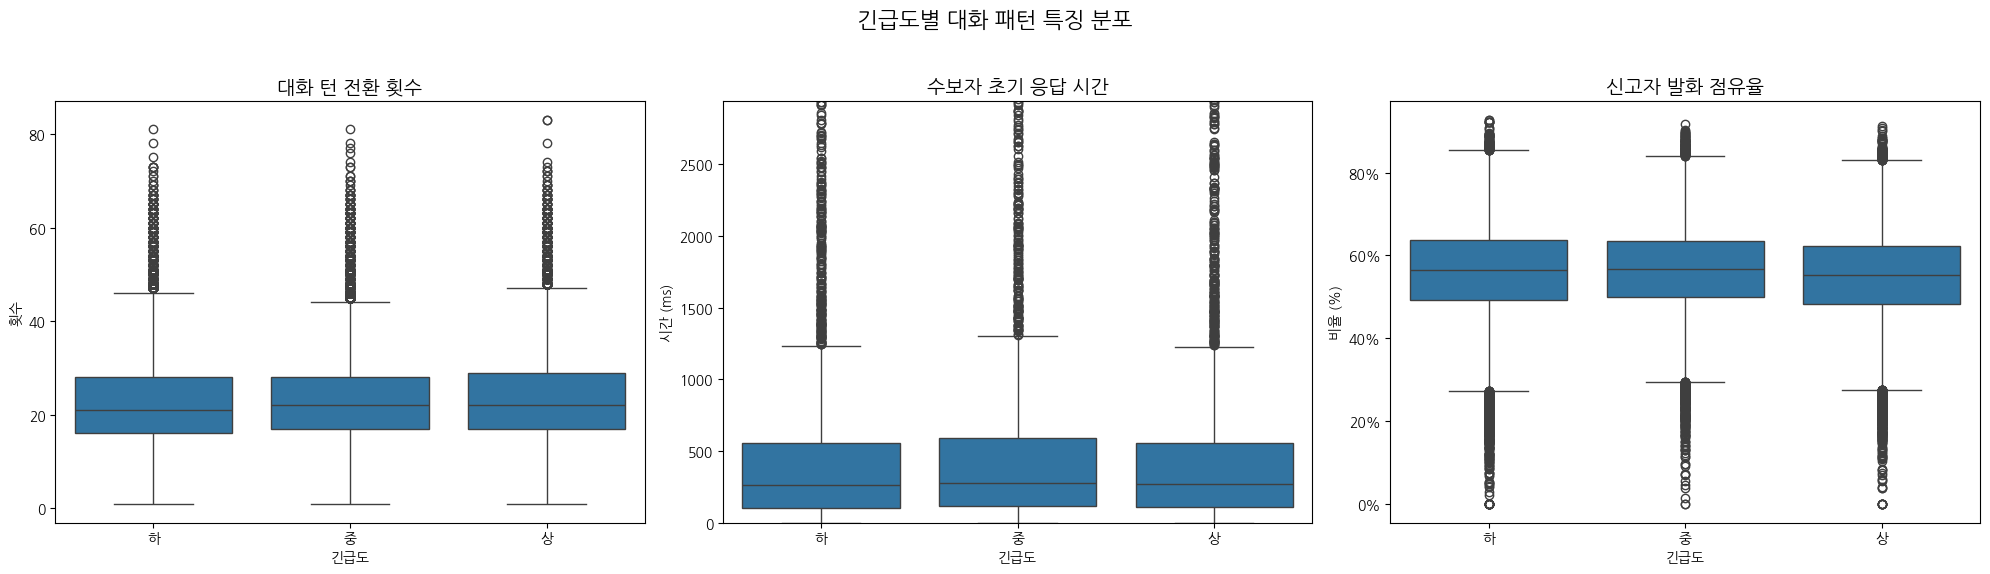

In [ ]:
# %% [EDA] 5. 종합 시각화 (Box Plots with Korean Font)
!pip install -q koreanize-matplotlib

import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 경고 메시지 무시 (선택 사항)
import warnings
warnings.filterwarnings('ignore')

print("📊 생성된 3가지 특징을 긴급도별로 시각화합니다.\n")

# 1. 시각화를 위한 Figure와 Axes 준비
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('긴급도별 대화 패턴 특징 분포', fontsize=16)

# 분석의 일관성을 위해 긴급도 순서를 ('하', '중', '상')으로 지정합니다.
urgency_order = ['하', '중', '상']

# 2. 첫 번째 그래프: 대화 턴 전환 횟수
sns.boxplot(x='urgencyLevel', y='turn_count', data=calls_df, ax=axes[0], order=urgency_order)
axes[0].set_title('대화 턴 전환 횟수', fontsize=14)
axes[0].set_xlabel('긴급도')
axes[0].set_ylabel('횟수')

# 3. 두 번째 그래프: 초기 응답 시간
sns.boxplot(x='urgencyLevel', y='initial_response_ms', data=calls_df, ax=axes[1], order=urgency_order)
axes[1].set_title('수보자 초기 응답 시간', fontsize=14)
axes[1].set_xlabel('긴급도')
axes[1].set_ylabel('시간 (ms)')
# Y축 범위를 조정하여 이상치 때문에 분포가 잘 안 보이는 현상을 방지합니다.
if not calls_df['initial_response_ms'].dropna().empty:
    p95 = calls_df['initial_response_ms'].quantile(0.95)
    axes[1].set_ylim(0, p95)

# 4. 세 번째 그래프: 신고자 발화 점유율
sns.boxplot(x='urgencyLevel', y='caller_talk_ratio', data=calls_df, ax=axes[2], order=urgency_order)
axes[2].set_title('신고자 발화 점유율', fontsize=14)
axes[2].set_xlabel('긴급도')
axes[2].set_ylabel('비율 (%)')
axes[2].set_yticklabels([f'{y:.0%}' for y in axes[2].get_yticks()])

# 그래프 레이아웃을 보기 좋게 조정하고 출력합니다.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# 1단계에서 처리한 결과를 파일로 저장
# 결과를 저장할 폴더를 하나 만들어 줍니다.
PROCESSED_DIR = "/content/drive/MyDrive/project1/Processed_Data"
os.makedirs(PROCESSED_DIR, exist_ok=True)

calls_df.to_feather(os.path.join(PROCESSED_DIR, 'calls_df_preprocessed.feather'))
utts_df.to_feather(os.path.join(PROCESSED_DIR, 'utts_df_preprocessed.feather'))

print(f"✅ 전처리된 데이터프레임이 '{PROCESSED_DIR}'에 저장되었습니다.")

✅ 전처리된 데이터프레임이 '/content/drive/MyDrive/project1/Processed_Data'에 저장되었습니다.
